In [1]:
import os
import re
# from tqdm import tqdm
import numpy as np
import pandas as pd
# import nltk
# nltk.download("all")
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/tamil_offensive_full_train.csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)

In [4]:
val = pd.read_csv('/content/drive/MyDrive/Datasets/tamil_offensive_full_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)

In [5]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)

In [ ]:
# !pip install fastText

In [ ]:
# import fasttext.util
# fasttext.util.download_model('ta', if_exists='ignore')  # Tamil
# ft = fasttext.load_model('cc.ta.300.bin')

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [7]:
tokenizer.fit_on_texts(train['text'].values)
X_train = tokenizer.texts_to_sequences(train['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [8]:
tokenizer.fit_on_texts(val['text'].values)
X_val = tokenizer.texts_to_sequences(val['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [9]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2021-01-07 04:40:27--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-07 04:40:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.04MB/s    in 6m 27s  

2021-01-07 04:46:54 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [10]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_index = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
glove_file.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [12]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

72158
2001


In [39]:
from tensorflow.keras import backend as K
K.clear_session()
# from keras.models import Sequential
from keras.initializers import Constant
from keras import layers
from keras.layers import Input
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, Conv1D, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.losses import kullback_leibler_divergence
embed_dim = 100

# model = Sequential()
inputs = Input(shape=(512,))
# model.add(layers.Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix), input_length=X_train.shape[1]))
x = Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix), input_length=X_train.shape[1])(inputs)
# model.add(layers.Conv1D(128, 5, activation='relu'))
conv2 = Conv1D(128, 5, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
drop21 = Dropout(0.5)(conv2)
conv22 = Conv1D(64, 5, activation='relu')(drop21)
drop22 = Dropout(0.5)(conv22)

lstm1 = Bidirectional(LSTM(128, return_sequences = True, dropout=0.2))(drop22)
# lstm2 = Bidirectional(LSTM(64, return_sequences = True))(lstm1)

flat = Flatten()(lstm1)
# dense = Dense(128, activation='relu')(flat)
out = Dense(32, activation='relu')(flat)
outputs = Dense(6, activation='softmax')(flat)
model = Model(inputs,outputs)


# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(6, activation='softmax'))
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 128)          64128     
_________________________________________________________________
dropout (Dropout)            (None, 508, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 504, 64)           41024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 504, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 504, 256)          197632

In [40]:
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

In [41]:
model.compile(loss = 'kullback_leibler_divergence', optimizer=opt, metrics = ['accuracy'])

In [42]:
y_train=train['label']
y_val = val['label']

In [43]:
Y_train=pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values

In [44]:
history = model.fit(X_train, Y_train,batch_size = 1024, validation_data=(X_val,Y_val), epochs=10, verbose=2)

Epoch 1/10
35/35 - 940s - loss: 2.2391 - accuracy: 0.7050 - val_loss: 2.0059 - val_accuracy: 0.7277
Epoch 2/10
35/35 - 885s - loss: 1.9449 - accuracy: 0.7236 - val_loss: 1.8625 - val_accuracy: 0.7277
Epoch 3/10
35/35 - 881s - loss: 1.8132 - accuracy: 0.7236 - val_loss: 1.7473 - val_accuracy: 0.7277
Epoch 4/10
35/35 - 915s - loss: 1.7007 - accuracy: 0.7236 - val_loss: 1.6399 - val_accuracy: 0.7277
Epoch 5/10
35/35 - 881s - loss: 1.6043 - accuracy: 0.7236 - val_loss: 1.5480 - val_accuracy: 0.7277
Epoch 6/10
35/35 - 885s - loss: 1.5194 - accuracy: 0.7236 - val_loss: 1.4695 - val_accuracy: 0.7277
Epoch 7/10
35/35 - 879s - loss: 1.4429 - accuracy: 0.7236 - val_loss: 1.3983 - val_accuracy: 0.7277
Epoch 8/10
35/35 - 869s - loss: 1.3781 - accuracy: 0.7236 - val_loss: 1.3367 - val_accuracy: 0.7277
Epoch 9/10
35/35 - 862s - loss: 1.3190 - accuracy: 0.7235 - val_loss: 1.2831 - val_accuracy: 0.7277
Epoch 10/10
35/35 - 861s - loss: 1.2676 - accuracy: 0.7236 - val_loss: 1.2421 - val_accuracy: 0.7277

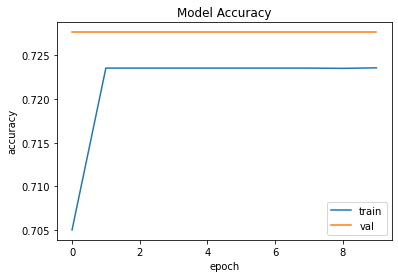

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [46]:
score = model.evaluate(X_val,Y_val,verbose=1)
predictions = np.argmax(model.predict(X_val),axis = -1)

print("Test score is {}".format(score[0]))
print("Test Accuracy is {}".format(score[1]))

138/138 [==============================] - 31s 227ms/step - loss: 1.2421 - accuracy: 0.7277
Test score is 1.2420847415924072
Test Accuracy is 0.7276663780212402


In [47]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_val, Y_val, verbose=0)

In [48]:
rounded_predictions = np.argmax(model.predict(X_val, batch_size=128, verbose=0),axis = -1)


In [49]:
import numpy as np
rounded_labels=np.argmax(Y_val, axis=1)

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(rounded_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      3193
           1       0.00      0.00      0.00       356
           2       0.00      0.00      0.00       295
           3       0.00      0.00      0.00       307
           4       0.00      0.00      0.00       172
           5       0.00      0.00      0.00        65

    accuracy                           0.73      4388
   macro avg       0.12      0.17      0.14      4388
weighted avg       0.53      0.73      0.61      4388



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
